<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Sampling-uniform-spanning-tree-with-zonotope-sampler" data-toc-modified-id="Sampling-uniform-spanning-tree-with-zonotope-sampler-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Sampling uniform spanning tree with zonotope sampler</a></span></li><li><span><a href="#Illustation-of-the-zonotope-walk" data-toc-modified-id="Illustation-of-the-zonotope-walk-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Illustation of the zonotope walk</a></span></li></ul></div>

In [1]:
import LinearAlgebra: dot
import SparseArrays: SparseMatrixCSC  # sparse constraint matrix for uniform spanning tree
using Random

using JuMP  # http://www.juliaopt.org/JuMP.jl/v0.19.0/installation/
# http://www.juliaopt.org/MathOptInterface.jl/
const MOI = JuMP.MOI

# Open source solvers
using GLPK  # https://github.com/JuliaOpt/GLPK.jl
using Clp  # https://github.com/JuliaOpt/Clp.jl

# Commercial solvers (academic licence possible)
using Gurobi  # https://github.com/JuliaOpt/Gurobi.jl
const GRB_ENV = Gurobi.Env()

check_random_state(seed::Nothing) = Random.MersenneTwister()
check_random_state(seed::Int) = Random.MersenneTwister(seed)
check_random_state(seed::Random.MersenneTwister) = seed

"""Check if passing initial points to solver is possible.
Note that it doesn't
"""
function is_warm_start_possible(model::JuMP.Model)::Bool
    return MOI.supports(
        JuMP.backend(model),
        MOI.VariablePrimalStart(),
        MOI.VariableIndex)
end


function select_solver(solver_name::String="glpk";
        mode::String="primal",
        tol::Float64=1e-5,
        verbose::Bool=false)::MOI.OptimizerWithAttributes

    if solver_name == "glpk"
        # http://www.maximalsoftware.com/solvopt/optglpk.html
        GLPK.jl_set_preemptive_check(false)
        solver = JuMP.optimizer_with_attributes(
            GLPK.Optimizer, 
            "msg_lev" => verbose ? GLPK.MSG_ON : GLPK.MSG_OFF,
            "meth" => mode == "primal" ? GLPK.PRIMAL : GLPK.DUAL,  # GLPK.DUALP
            "tol_bnd" => tol,
            "tol_obj" => tol
        )
    elseif solver_name == "clp"
        # https://github.com/JuliaOpt/Clp.jl
        solver = JuMP.optimizer_with_attributes(
            Clp.Optimizer, 
            "LogLevel" => verbose ? 1 : 0,
            "Algorithm" => mode == "primal" ? 1 : 0,  # dual simplex (0), primal simplex (1), sprint (2), barrier with crossover (3), barrier without crossover (4), automatic (5)
            "PrimalTolerance" => tol,
            "DualTolerance" => tol
        )
    elseif solver_name == "gurobi"
        # https://www.gurobi.com/documentation/9.0/refman/parameter_descriptions.html
        solver = JuMP.optimizer_with_attributes(
            () -> Gurobi.Optimizer(GRB_ENV), 
            "Presolve" => 0,  # off (0), conservative (1), or aggressive (2)
            "OutputFlag" => verbose ? 1 : 0,
            "Method" => mode == "primal" ? 0 : 1,  # 0=primal simplex, 1=dual simplex
            "OptimalityTol" => tol,
            "FeasibilityTol" => tol,
            "IntFeasTol" => tol,
        )
    else
        throw(ArgumentError("solver_name = $solver_name ∉ {\"glpk\", \"clp\", \"gurobi\"}"))
    end
    
    return solver
end

""" LP used in extract_basis
min c^⊤ y
s.t. 
   Φ y = x
   0 ≤ y ≤ 1
"""
function build_LP_ℬ(solver::MOI.OptimizerWithAttributes,
        Φ::Union{Array{T, 2}, SparseMatrixCSC{T, Int64}},
        x::Vector{Float64},
        c::Vector{Float64}
        )::JuMP.Model where T

    n, m = size(Φ)
    
    model = JuMP.Model(solver)
    JuMP.@variable(model, 0 <= y[i=1:m] <= 1)
    JuMP.@objective(model, MOI.MIN_SENSE, dot(c, y))
    JuMP.@constraint(model, con, Φ * y .== x)
    
    return model
    
end

""" LP used in find_min_max_steps_α
min -α
s.t. 
   α d + Φ y = x
   0 ≤ y ≤ 1
"""
function build_LP_α(solver::MOI.OptimizerWithAttributes,
        Φ::Union{Array{T, 2},SparseMatrixCSC{T, Int64}},
        x::Vector{Float64},
        d::Vector{Float64}
        )::JuMP.Model where T

    n, m = size(Φ)

    model = JuMP.Model(solver)
    JuMP.@variables(model,
               begin 
                   α
                   0 <= y[i=1:m] <= 1 
               end)
    JuMP.@objective(model, MOI.MIN_SENSE, -α)
    JuMP.@constraint(model, con, α * d + Φ * y .== x)

    return model
    
end
            

"""Return indices associated to basic variables {i ; 0 < y*ᵢ < 1} of LP_ℬ
"""
function extract_basis!(LP_ℬ::JuMP.Model, 
        x::Vector{Float64},
        warm_start=false
        )::Vector{Float64}

    JuMP.set_normalized_rhs.(LP_ℬ[:con], x)
    JuMP.optimize!(LP_ℬ)
    
    return findall(0 .< JuMP.value.(LP_ℬ[:y]) .< 1)
end


"""Compute min/max steps 
α_m/M = min/max -α
s.t. 
   Φ y = x - α d
   0 ≤ y ≤ 1
"""
function find_min_max_steps_α!(LP_α::JuMP.Model, 
        x::Vector{Float64}, 
        d::Vector{Float64},
        warm_start=false
        )::Tuple{Float64,Float64}
    
    JuMP.set_normalized_rhs.(LP_α[:con], x)
    JuMP.set_normalized_coefficient.(LP_α[:con], LP_α[:α], d)
    
    JuMP.set_objective_sense(LP_α, MOI.MIN_SENSE)
    JuMP.optimize!(LP_α)
    α_m = JuMP.objective_value(LP_α)

    if warm_start
        set_start_value.(all_variables(LP_α), value.(all_variables(LP_α)))
    end

    JuMP.set_objective_sense(LP_α, MOI.MAX_SENSE)
    JuMP.optimize!(LP_α)
    α_M = JuMP.objective_value(LP_α)
    
    return α_m, α_M
end


function ust_sampler_zonotope!(LP_ℬ::JuMP.Model, LP_α::JuMP.Model;
        nb_iter::Int64=10,
        save_bases::Bool=false,
        random_state::Union{Nothing, Int64, Random.MersenneTwister}=nothing
    )::Array{Int64, 2}
    
    rng = check_random_state(random_state)
    warm_start = is_warm_start_possible(LP_ℬ)

    x = JuMP.normalized_rhs.(LP_ℬ[:con])  # initial point in 𝒵onotope(Φ)
    d = JuMP.normalized_coefficient.(LP_α[:con], LP_α[:α])  # initial hit-and-run direction
    
    ℬ = zeros(Int64, length(x), save_bases ? nb_iter : 1)
    
    for it in 1:(nb_iter-1)

        if save_bases
            ℬ[:, it] = extract_basis!(LP_ℬ, x, warm_start)
        end
        
        # From x move in the direction d while staying in 𝒵onotope(Φ)
        α_m, α_M = find_min_max_steps_α!(LP_α, x, d, warm_start)
        x .+= (α_m + (α_M - α_m) * Random.rand(rng)) .* d
        
        # Take a random (uniform) direction from x
        Random.randn!(rng, d)
        
    end
    
    ℬ[:, end] = extract_basis!(LP_ℬ, x)

    return ℬ
end


function zonotope_sampler_volume_target_demo(LP_ℬ::JuMP.Model, LP_α::JuMP.Model;
        nb_iter::Int64=10,
        random_state::Union{Nothing, Int64, Random.MersenneTwister}=nothing
    )::Tuple{Array{Float64,2}, Array{Float64,2}, Array{Float64,2}, Array{Int64,2}}
    
    rng = check_random_state(random_state)
    warm_start = is_warm_start_possible(LP_ℬ)

    x = JuMP.normalized_rhs.(LP_ℬ[:con])  # initial point in 𝒵onotope(Φ)
    d = JuMP.normalized_coefficient.(LP_α[:con], LP_α[:α])  # initial hit-and-run direction
    
    rec_x = zeros(Float64, length(x), nb_iter)
    rec_x_m = zeros(Float64, length(x), nb_iter)
    rec_x_M = zeros(Float64, length(x), nb_iter)
    ℬ = zeros(Int64, length(x), nb_iter)
    
    for it in 1:(nb_iter-1)
        rec_x[:, it] = x
        ℬ[:, it] = extract_basis!(LP_ℬ, x, warm_start)
        
        # From x move in the direction d while staying in 𝒵onotope(Φ)
        α_m, α_M = find_min_max_steps_α!(LP_α, x, d, warm_start)
        rec_x_m[:, it+1] = x + α_m * d
        rec_x_M[:, it+1] = x + α_M * d
        x .+= (α_m + (α_M - α_m) * rand(rng)) .* d
        
        # Take a random (uniform) direction from x
        randn!(rng, d)
        
    end
    
    rec_x[:, end] = x
    ℬ[:, end] = extract_basis!(LP_ℬ, x, warm_start)
    
    return rec_x, rec_x_m, rec_x_M, ℬ

end

Academic license - for non-commercial use only


zonotope_sampler_volume_target_demo (generic function with 1 method)

## Sampling uniform spanning tree with zonotope sampler

**Define the graph**

In [11]:
using LightGraphs
# g = complete_graph(100)
g = LightGraphs.grid([30, 30])
Φ = LightGraphs.incidence_matrix(g, oriented=true)[1:end-1, :];

**Speed** gurobi > glpk > clp

**Memory allocation** glpk > gurobi > clp

In [12]:
n, m = size(Φ)
rng = check_random_state(0)
x, c, d = Φ * Random.rand(rng, m), Random.randn(rng, m), Random.randn(rng, n)

# Solvers I've made tests with
# glpk (free), clp (free), gurobi (commercial)
solver = select_solver("glpk")  # default glpk 
LP_ℬ = build_LP_ℬ(solver, Φ, x, c)
LP_α = build_LP_α(solver, Φ, x, d);

nb_iter = 10
save_bases = false  # save basis at each or only last iter@fation

false

In [17]:
@time ust_sampler_zonotope!(LP_ℬ, LP_α, 
    nb_iter=nb_iter, save_bases=save_bases, random_state=rng);

  0.344990 seconds (147.59 k allocations: 6.703 MiB)


In [14]:
@time ust_sampler_zonotope!(LP_ℬ, LP_α, 
    nb_iter=nb_iter, save_bases=save_bases, random_state=rng);

  0.456959 seconds (147.59 k allocations: 6.703 MiB)


## Illustation of the zonotope walk

In [5]:
Φ = [1.0 2.0 0.0 -1.0; 
     0.0 1.0 2.0 1.0]

n, m = size(Φ)
rng = check_random_state(234)
x, c, d = Φ * rand(rng, m), randn(rng, m), randn(rng, n)

solver = select_solver("glpk")
LP_ℬ = build_LP_ℬ(solver, Φ, x, c)
LP_α = build_LP_α(solver, Φ, x, d);

nb_iter = 10
points, points_m, points_M, bases = zonotope_sampler_volume_target_demo(LP_ℬ, LP_α, 
    nb_iter=nb_iter, random_state=rng)

([1.8183064010504946 1.786143923445536 … -0.3876960542017998 2.2439652851619343; 2.203516492147835 2.939894074460561 … 0.6935277565825714 3.2699874906973436], [0.0 1.7398420887509458 … -1.0 -0.542232681932252; 0.0 4.0 … 1.8812451417282925 0.5422326819322524], [0.0 1.895003181741348 … -0.06225708230314331 2.4895647385597943; 0.0 0.4475015908706743 … 0.06225708230314331 3.5104352614402052], [1 1 … 2 3; 3 3 … 4 4])

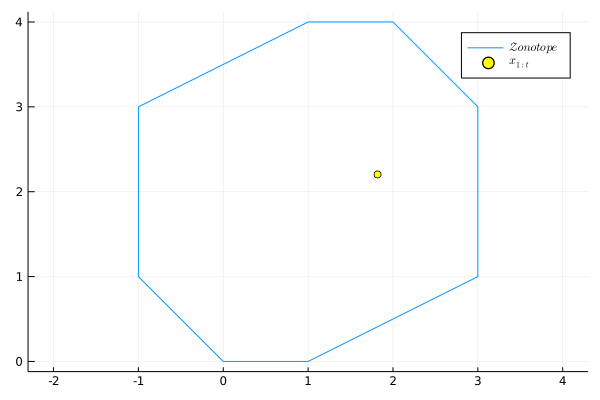

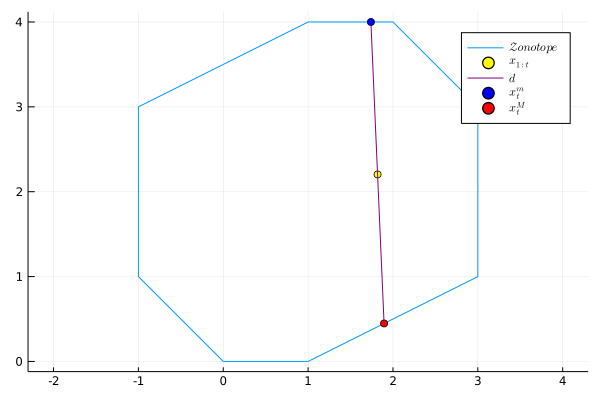

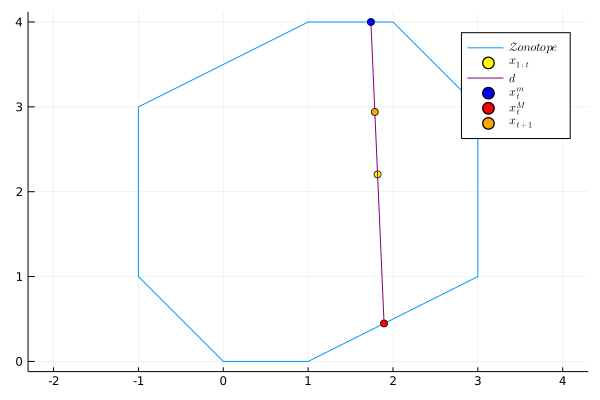

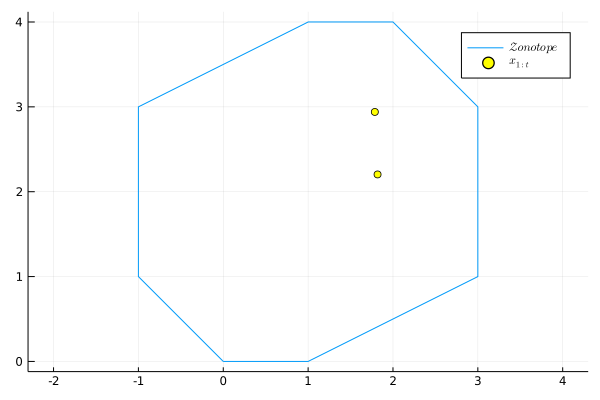

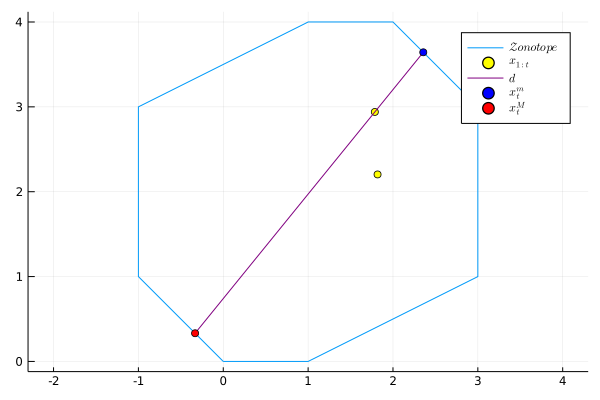

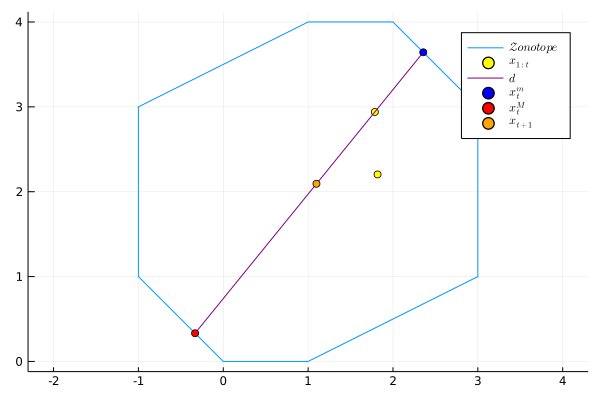

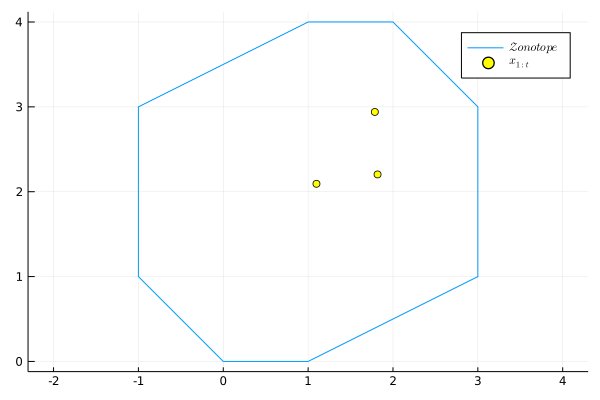

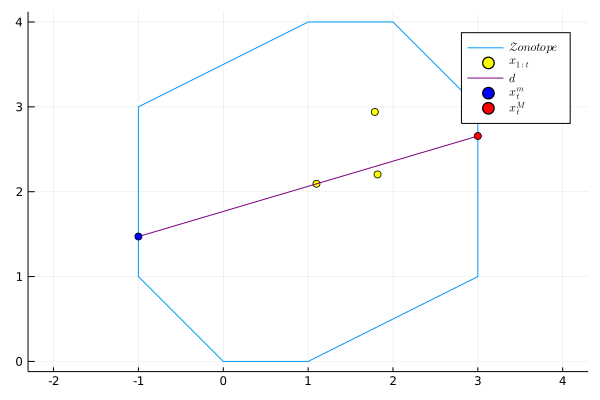

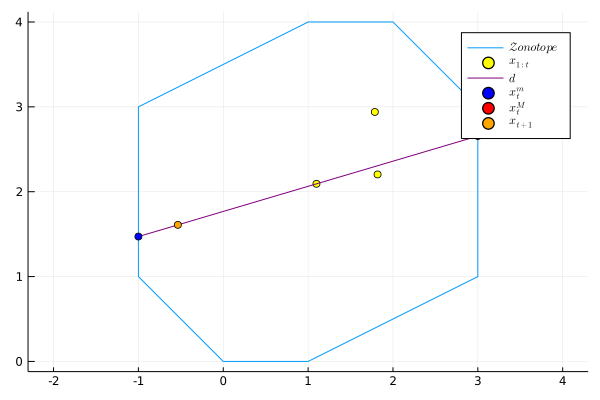

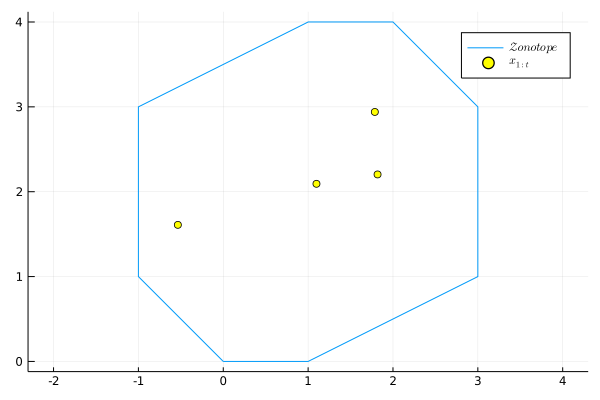

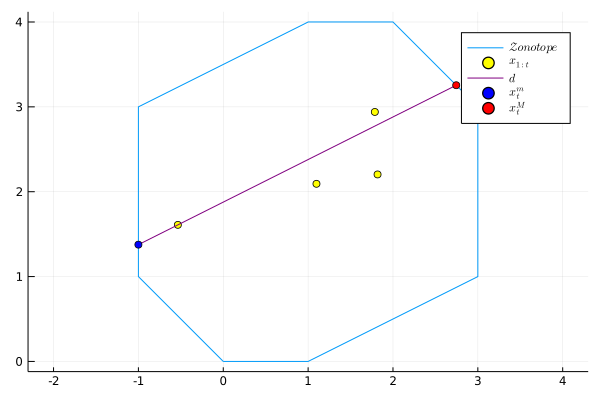

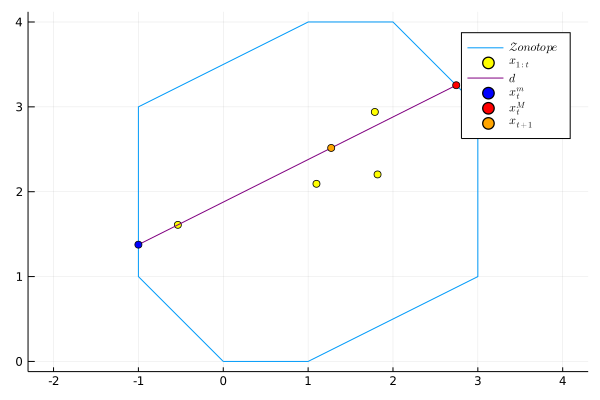

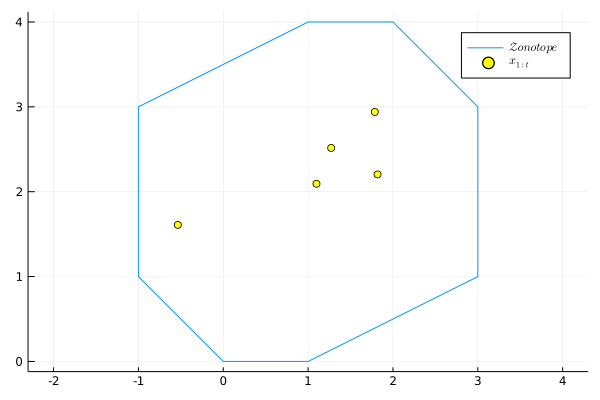

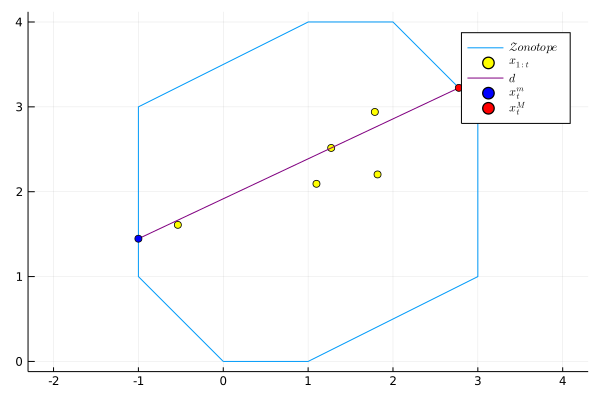

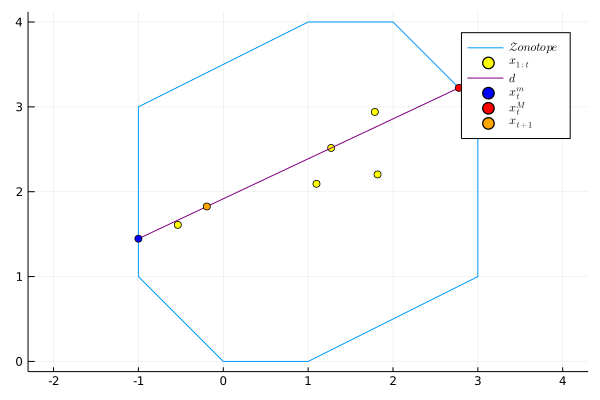

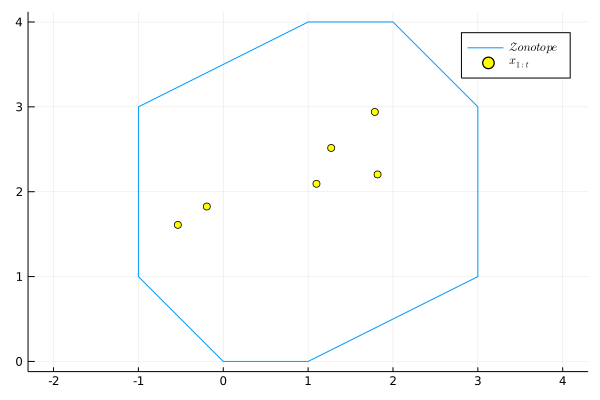

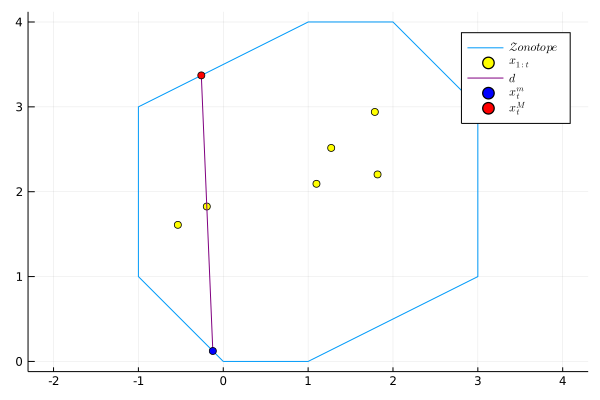

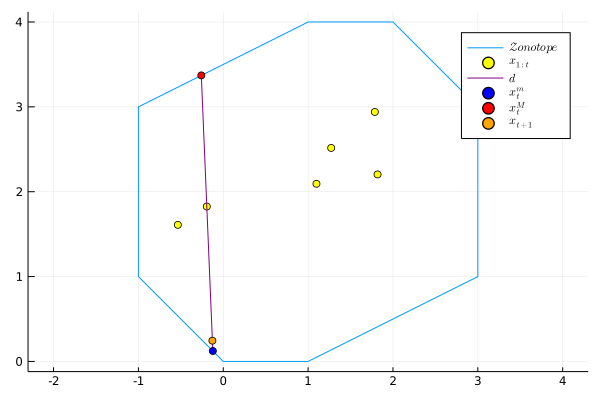

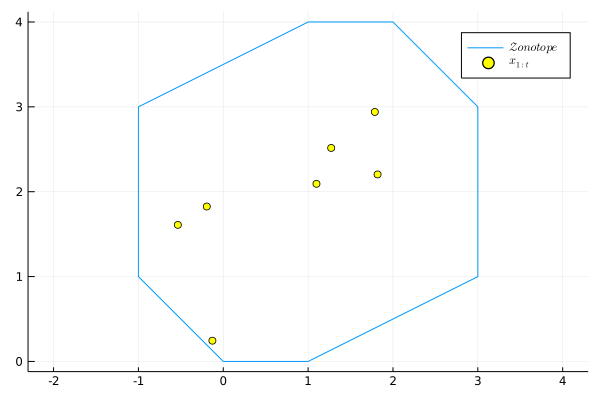

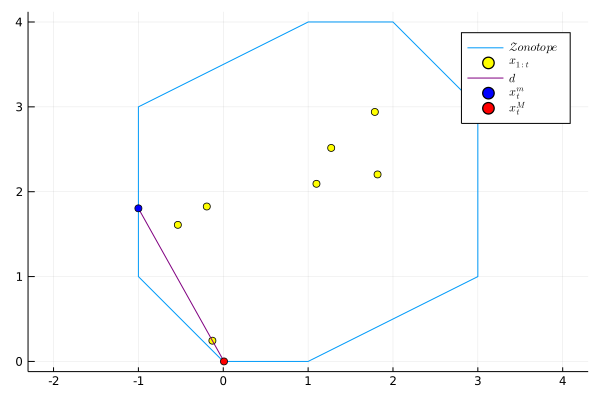

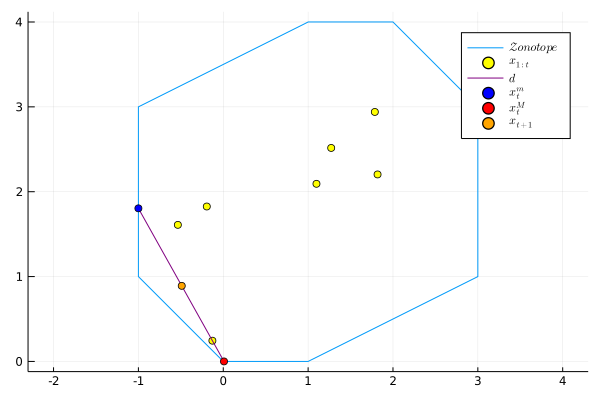

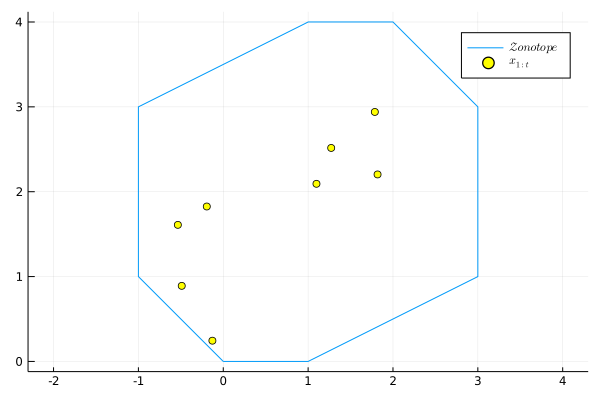

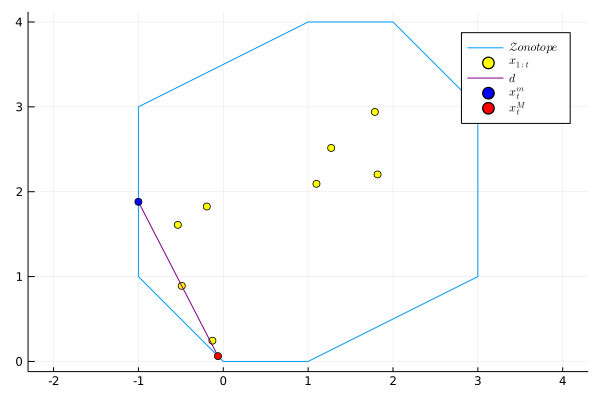

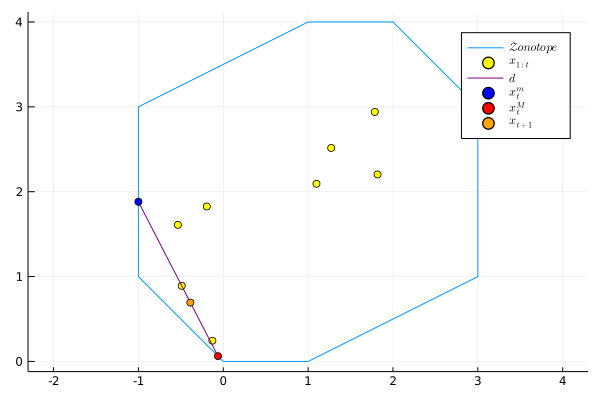

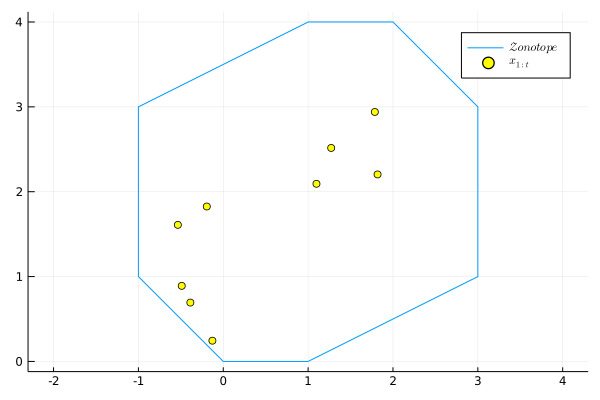

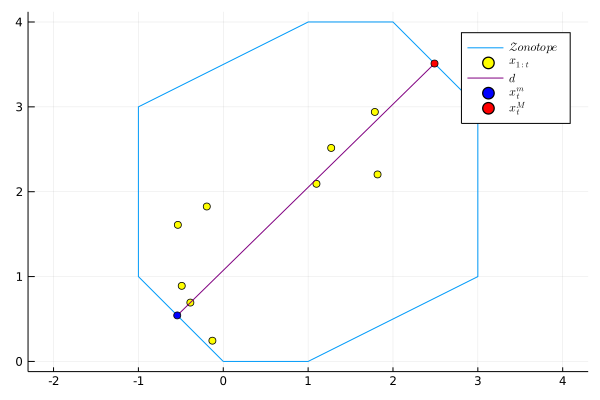

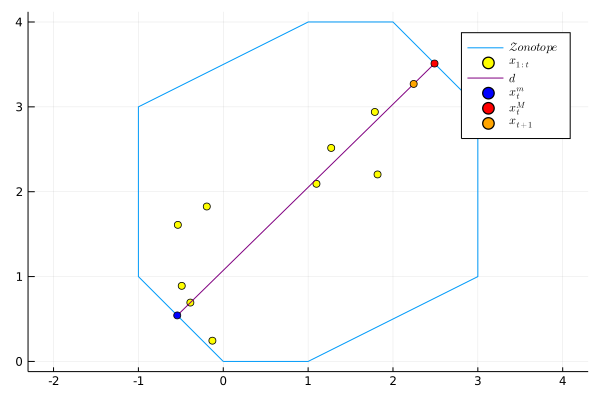

In [6]:
using Plots
using LaTeXStrings
# Φ = [1.0 2.0 0.0 -1.0; 
#      0.0 1.0 2.0 1.0]
vertices = [0 0; 1 0; 3 1; 3 3; 2 4; 1 4; -1 3; -1 1; 0 0]

for (i, (x, x_m, x_M, x̃)) in enumerate(zip(eachcol(points[:, 1:end-1]), 
                            eachcol(points_m[:, 2:end]), 
                            eachcol(points_M[:, 2:end]),
                            eachcol(points[:, 2:end])))
    
    p = plot(vertices[:, 1], vertices[:, 2], aspect_ratio=:equal, label=L"$\mathcal{Z}onotope$")
    scatter!(points[1, 1:i], points[2, 1:i], label=L"$x_{1:t}$", markercolor="yellow")
#     scatter!([x[1]], [x[2]], label=L"$x_{t}$", markercolor="orange")
    display(p)

    plot!([x_m[1], x_M[1]], [x_m[2], x_M[2]], label=L"$d$", linecolor="purple")
    scatter!([x_m[1]], [x_m[2]], label=L"$x_{t}^m$", markercolor="blue")
    scatter!([x_M[1]], [x_M[2]], label=L"$x_{t}^M$", markercolor="red")
    display(p)

    scatter!([x̃[1]], [x̃[2]], label=L"$x_{t+1}$", markercolor="orange")
    display(p)

end